# Data setup

In [13]:
import numpy as np
from scipy.optimize import minimize
from scipy.stats import norm, multivariate_normal
from functools import partial
import matplotlib.pyplot as plt
import seaborn as sns
import gpytorch
import torch
%matplotlib inline


In [3]:


def sigma_fn(c, w_0=0.5, w_1=7):
    return w_0 ** 2 + (w_1 ** 2) * c

def sigma_dw_0(c, w_0, w_1):
    return 2 * w_0

def sigma_dw_1(c, w_0, w_1):
    return 2 * w_1 * c

num_samples = 10000
x = np.array([3])

c = np.random.rand(num_samples)
sigma_2 = sigma_fn(c)

eps = []

for sigma in sigma_2:
    assert sigma > 0, f'Sigma is {sigma}'
    noise = norm(scale=sigma ** 0.5).rvs(1)
    eps.append(noise)

eps = np.array(eps).squeeze()
assert eps.shape == (num_samples,)
y = x + eps

/Users/jinmeng1/opt/miniconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


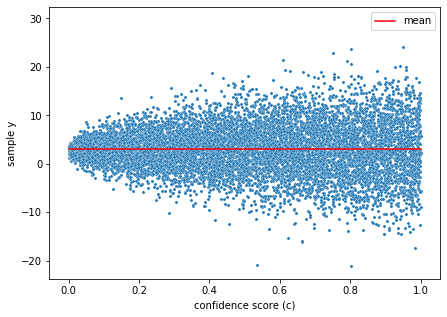

In [4]:
plt.figure(figsize=(7, 5))
sns.scatterplot(c, y, s=10)

# Bigger c value = more variance/uncertainty
plt.xlabel('confidence score (c)')
plt.ylabel('sample y')
plt.plot([0, 1], [y.mean(), y.mean()], 'r', label='mean')
plt.legend(loc='upper right');

In [5]:
y[c < 0.1].std(), y[c > 0.9].std()

(1.6473964445074039, 6.717461415891308)

# 1.1: Frequentist approach

In [5]:
def l_dmu(mu, w_0, w_1):
    return ((y - mu) / sigma_fn(c, w_0, w_1)).sum()

def l_dw0(mu, w_0, w_1):
    return 0.5 * ((y - mu) ** 2 / (sigma_fn(c, w_0, w_1) ** 2) * sigma_dw_0(c, w_0, w_1)
            - (sigma_dw_0(c, w_0, w_1) / sigma_fn(c, w_0, w_1))).sum()

def l_dw1(mu, w_0, w_1):
    return 0.5 * ((y - mu) ** 2 / (sigma_fn(c, w_0, w_1) ** 2) * sigma_dw_1(c, w_0, w_1)
            - (sigma_dw_1(c, w_0, w_1) / sigma_fn(c, w_0, w_1))).sum()

In [6]:
def l_jac(params):
    mu, w_0, w_1 = params
    return - np.array([l_dmu(mu, w_0, w_1),
                     l_dw0(mu, w_0, w_1),
                     l_dw1(mu, w_0, w_1),
                    ])

In [7]:
def log_fn(params):
    mu = params[0]
    w_0 = params[1]
    w_1 = params[2]
    
    first = (y - mu) ** 2 / sigma_fn(c, w_0=w_0, w_1=w_1)
    second = np.log(sigma_fn(c, w_0=w_0, w_1=w_1))
    return first.sum() + second.sum()

minimize(log_fn, [3, 0.5, 0.1], jac=l_jac, method='Newton-CG')

     fun: 39409.07247688987
     jac: array([ 0.00734549,  0.01314383, -0.00247802])
 message: "Warning: CG iterations didn't converge. The Hessian is not positive definite."
    nfev: 32
    nhev: 0
     nit: 28
    njev: 211
  status: 3
 success: False
       x: array([2.97365133, 0.47757801, 7.03229228])

In [8]:
mu_mle, w0_mle, w1_mle = minimize(log_fn, [3, 0.5, 0.1], jac=l_jac, method='Newton-CG').x
mu_mle, w0_mle, w1_mle

(2.97365133449137, 0.4775780085602843, 7.0322922779614885)

# 1.2 Frequentist Regression

In [8]:
def sigma_fn_2(c, v_0=0.5, v_1=7):
    return v_0 ** 2 + (v_1 ** 2) * c

def sigma_2_dv_0(c, v_0, v_1):
    return 2 * v_0

def sigma_2_dv_1(c, v_0, v_1):
    return 2 * v_1 * c

def phi(x):
    return np.array([x ** 0, x, x ** 2]).squeeze()

num_samples = 1000

# x = np.random.randint(0, 101, size=num_samples)
# x = np.random.rand(num_samples)
x = np.linspace(-11,10, num_samples)

# c = np.zeros(num_samples)
c = np.random.rand(num_samples) + 10

# w_0 = 13
# w_1 = 0.9
# w_2 = 0.02
# v_0 = 0.01
# v_1 = 0

w_0 = 1.3
w_1 = 12
w_2 = 21
v_0 = 10
v_1 = 33


w = np.array([w_0, w_1, w_2]).squeeze()
v = np.array([v_0, v_1]).squeeze()
sigma_2 = sigma_fn_2(c, v_0=v_0, v_1=v_1)

eps = []

for sigma in sigma_2:
    assert sigma > 0, f'Sigma is {sigma}'
    noise = norm(scale=sigma ** 0.5).rvs(1)
    eps.append(noise)

eps = np.array(eps).squeeze()
assert eps.shape == (num_samples,)
# assert x.shape == (num_samples,)
y = w.T @ phi(x) + eps
y_true = w.T @ phi(x)
assert y.shape == (num_samples,)
assert y_true.shape == (num_samples,)

In [9]:
# sigma_2 = sigma_fn_2(c, v_0=v_0, v_1=v_1)
# plt.hist(np.random.normal(loc = w.T @ phi(x), scale=sigma_2), bins=20)
# plt.hist(y)

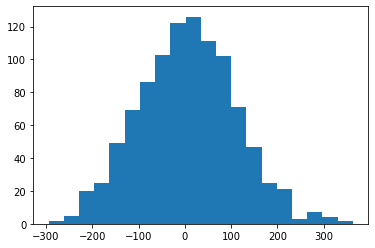

In [10]:
plt.hist(eps, bins=20);

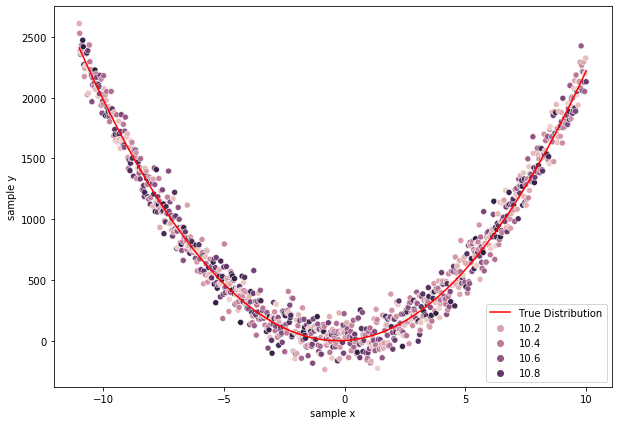

In [11]:
plt.figure(figsize=(10, 7))
sns.scatterplot(x,
                y,
                hue=c,
                )
plt.plot(x, y_true, 'r', label="True Distribution")
plt.xlabel('sample x')
plt.ylabel('sample y')
plt.legend(loc='lower right');

In [13]:
def log_fn(params):
    w = params[0: 3]
    v = params[3: ]

    first = (w.T @ phi(x) - y) ** 2 / sigma_fn_2(c, *v)
    second = np.log(sigma_fn_2(c, *v))
    return - 0.5 * (first.sum() + second.sum())

In [14]:
# def l_deriv_w(w, v):
#     F_minus1 = np.linalg.inv(F(v) ** 0.5)
#     result = Phi.T @ F_minus1 @ Phi @ w - Phi.T @ F_minus1 @ y
#     #result = phi(x) @ ((w.T @ phi(x) - y) / sigma_fn_2(c, *v))
#     return - result

# grad_epsilon = 1e-6
# w = start[0: 3]
# v = start[3: ]
# w_plus = np.array([w_0 + grad_epsilon, w_1, w_2]).squeeze()
# w_minus = np.array([w_0 - grad_epsilon, w_1, w_2]).squeeze()
# v = np.array([v_0, v_1])
# approx_gradient = (log_fn(np.concatenate([w_plus, v]))
#                    - log_fn(np.concatenate([w_minus, v]))
#                    ) / (2 * grad_epsilon)
# distance = np.linalg.norm(l_deriv_w(w, v)[0] - approx_gradient.item())

# distance

In [15]:
# deriv_w = - (Phi @ F_inv @ Phi.T @ w - Phi @ F_inv @ y)
# deriv_v0 = ((w @ Phi - y) * sigma_2_dv_0(c, *v) / (sigma_fn_2(c, *v) ** 2)).sum() - (sigma_2_dv_0(c, *v) / sigma_fn_2(c, *v)).sum()
# deriv_v1 = ((w @ Phi - y) * sigma_2_dv_1(c, *v) / (sigma_fn_2(c, *v) ** 2)).sum() - (sigma_2_dv_1(c, *v) / sigma_fn_2(c, *v)).sum()

Phi = phi(x)
F = sigma_2 * np.eye(len(sigma_2))
F_inv = np.linalg.inv(F)


def l_deriv_w(w, v):
    # F_minus1 = np.linalg.inv(F(v))
    # result = Phi.T @ F_minus1 @ Phi @ w - Phi.T @ F_minus1 @ y
    # result = Phi.T @ ((w.T @ Phi - y) / sigma_fn_2(c, *v))
    result = Phi @ F_inv @ Phi.T @ w - Phi @ F_inv @ y
    return - result

def l_deriv_v0(w, v):
    first = (w @ Phi - y) * sigma_2_dv_0(c, *v) / (sigma_fn_2(c, *v) ** 2)
    second = sigma_2_dv_0(c, *v) / sigma_fn_2(c, *v)
    return first.sum() - second.sum()

def l_deriv_v1(w, v):
    first = (w @ Phi - y) * sigma_2_dv_1(c, *v) / (sigma_fn_2(c, *v) ** 2)
    second = sigma_2_dv_1(c, *v) / sigma_fn_2(c, *v)
    return first.sum() - second.sum()

def l_jac(params):
    w = params[0: 3]
    v = params[3: ]
    return - np.array([*l_deriv_w(w, v),
                       l_deriv_v0(w, v),
                       l_deriv_v1(w, v),
                       ])

In [16]:
# start = np.array([14, 1, 0.03, 12, 75])

minimize(log_fn, np.append(w,v), jac=l_jac, method='Newton-CG').x

array([ 1.31568701, 11.86638643, 22.29756805,  9.85517098, 27.98130852])

In [17]:
# print(start)
# end = start.copy()
# for _ in range(10):
#     end += 1e-4 * l_jac(end)
# print(end)

In [18]:
w_0_mle, w_1_mle, w_2_mle, v_0_mle, v_1_mle = minimize(log_fn, np.append(w,v), jac=l_jac, method='CG').x
w_0_mle, w_1_mle, w_2_mle, v_0_mle, v_1_mle

(1.3058443841243434,
 11.275391874131818,
 22.975659794584274,
 9.031755050241644,
 -0.2884779117708973)

# 1.3 Bayesian approach

## Generate Sample Data
Data generated according to:
$$y = f(x) + \epsilon(c) \hspace{.3cm} f \sim GP(0,k)$$

For this example we will choose an RBF kernel

In [507]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, kernel):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = kernel

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

n_samples = 100
    
test_x = torch.linspace(1, 100, n_samples)
    
### Make GP

likelihood = gpytorch.likelihoods.GaussianLikelihood()
# RBF_kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
RBF_kernel = gpytorch.kernels.RBFKernel()
RBF_kernel.has_lengthscale = True
RBF_kernel.lengthscale = 10
RBF_kernel = gpytorch.kernels.ScaleKernel(RBF_kernel)
RBF_model = ExactGPModel(None, None, likelihood, RBF_kernel)
RBF_model.covar_module.outputscale = 10
RBF_model.eval()


RBF_pred = RBF_model(test_x)
RBF_samples = RBF_pred.rsample(sample_shape=torch.Size([1]))


def sigma_fn_3(c, v_0=0, v_1=1):
    return v_0 + v_1 * c



### Make Sigma Values
c = np.random.normal(size=n_samples)
sigma2 = sigma_fn_3(c)

### Make Sample Data
y = (RBF_samples.detach().numpy() + sigma2)[0]

/Users/jinmeng1/opt/miniconda3/lib/python3.7/site-packages/gpytorch/utils/cholesky.py:46: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


(array([ 3., 11., 13., 11., 10., 17., 13., 11.,  8.,  3.]),
 array([-1.62993686, -1.26340684, -0.89687682, -0.5303468 , -0.16381678,
         0.20271325,  0.56924327,  0.93577329,  1.30230331,  1.66883333,
         2.03536335]),
 <a list of 10 Patch objects>)

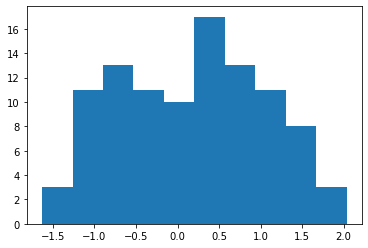

In [508]:
### Checking for Gaussian Noise
plt.hist(sigma2)

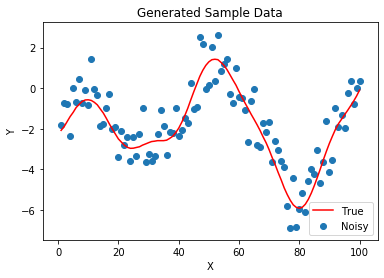

In [509]:
### Plotting Noisy Data vs. True Function
plt.plot(test_x,RBF_samples.detach().numpy()[0], 'r-', label="True")
plt.scatter(test_x, y, label="Noisy")
plt.title("Generated Sample Data")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend(loc="lower right")

## Derivative Equations

Marginal Likelihood: 
$$ \ell(\theta, v)  = \log p(y| \theta, v) = -\frac{1}{2} y^T(K_\theta + F)^{-1} y - \frac{1}{2} \log|K_\theta + F| - \frac{N}{2} \log(2 \pi) $$

$$\alpha =(K_\theta + F)^{-1}y $$


Derivative Equations: 
$$
\begin{align}
    \frac{\partial \ell}{\partial v_j} = \frac{1}{2} \text{tr}(\alpha \alpha^T  - (K_\theta + F)^{-1} \frac{\partial F}{\partial v_j}  ) \\
    \frac{\partial \ell}{\partial \theta_j} = \frac{1}{2} \text{tr}(\alpha \alpha^T  - (K_\theta + F)^{-1} \frac{\partial K_{\theta}}{\partial \theta_j}  )
\end{align}
$$

$$ \theta_1 = \text{Lengthscale}, \theta_2 = \text{Output Scale} $$


For an RBF Kernel, K is:

$$
\begin{align}
    K_{\theta} = a^2 exp(-\frac{||x-x'||^2}{2 L^2})
\end{align}
$$

$$
\begin{align}
    \frac{\partial K_{\theta}}{\partial \text{a}} = 2a \cdot exp(-\frac{||x-x'||^2}{2 L^2})
\end{align}
$$

$$
\begin{align}
    \frac{\partial K_{\theta}}{\partial \text{L}} = \Big(K_{\theta} \Big) \Big(\frac{||x-x'||^2}{L^3} \Big)
\end{align}
$$


In [510]:
K_theta = RBF_kernel(test_x).evaluate()
F = sigma2 * np.eye(len(sigma2))

KF_inv = np.linalg.inv(K_theta.detach().numpy() + F)
alpha = KF_inv @ y

lengthscale = RBF_model.covar_module.base_kernel.lengthscale.item()
outputscale = RBF_model.covar_module.outputscale.item()


dK_lengthscale = KF_inv @ ((np.log(K_theta.detach().numpy() / outputscale) * -2) / np.sqrt(lengthscale))
dK_outputscale = 2 * (K_theta / outputscale) * np.sqrt(outputscale)
dK_outputscale = dK_outputscale.detach().numpy()

dF_dv0 = np.eye(len(sigma2))
dF_dv1 = np.eye(len(sigma2)) * c



### Final Derivative Equations
dL_lengthscale = .5 * np.trace(alpha @ alpha.T - dK_lengthscale)
dL_outputscale = .5 * np.trace(alpha @ alpha.T - KF_inv @ dK_outputscale)
dL_dv0 = .5 * np.trace(alpha @ alpha.T - KF_inv @ dF_dv0)
dL_dv1 = .5 * np.trace(alpha @ alpha.T - KF_inv @ dF_dv1)

dL_lengthscale, dL_outputscale, dL_dv0, dL_dv1

(376365.6983236111, 376361.96757029643, 376352.4423123115, 376321.3719725194)